In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

api_token = '<YOUR API TOKEN>'
list_of_assets = ['SPY.US', 'VGT.US', 'XAUUSD.FOREX', 'DXY.INDX', 'VBTIX.US', 'VTWO.US', 'EEM.US', 'BTC-USD.CC']

dfs_to_concat = []

for asset in list_of_assets:
    url = f'https://eodhd.com/api/eod/{asset}'
    query = {'api_token': api_token, "fmt": "json"}
    response = requests.get(url, params=query)
    if response.status_code != 200:
        print(f"Error fetching data for {asset}: {response.status_code}")
    else:
        data_eod_history = response.json()
        df_prices = pd.DataFrame(data_eod_history)
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        df_prices = df_prices.set_index('date')['adjusted_close']
        df_prices = df_prices.to_frame(name=f'{asset}')
        dfs_to_concat.append(df_prices)

df_eod_prices = pd.concat(dfs_to_concat, axis=1)

# Since we have crypto, the result will have weekends also, so we need to forward fill the dataframe with Friday's price
df_eod_prices = df_eod_prices.ffill()
# keep the x years of data
years_to_keep = 10
x_years_ago = datetime.today() - timedelta(days=years_to_keep*365)
df_eod_prices = df_eod_prices[df_eod_prices.index > x_years_ago]
df_eod_prices

,SPY.US,VGT.US,XAUUSD.FOREX,DXY.INDX,VBTIX.US,VTWO.US,EEM.US,BTC-USD.CC
date,,,,,,,,
2015-04-21,176.3519,97.2315,1202.6800,98.004,8.4039,44.0098,34.4074,235.269000
2015-04-22,177.2185,98.1686,1187.3000,97.932,8.3733,44.0667,34.7762,234.176000
2015-04-23,177.6644,98.4029,1194.0000,97.278,8.3886,44.2898,35.0328,236.462000
2015-04-24,178.0767,98.9616,1179.3800,96.922,8.4039,44.1498,35.1571,231.268000
2015-04-25,178.0767,98.9616,1179.3800,96.922,8.4039,44.1498,35.1571,226.390000
...,...,...,...,...,...,...,...,...
2025-04-13,533.9400,520.1400,3223.9299,100.102,9.4800,74.4700,41.7500,83684.979028
2025-04-14,539.1200,523.8100,3209.2849,99.640,9.5400,75.3900,42.1300,84542.391283
2025-04-15,537.6100,525.7900,3227.6050,100.215,9.5500,75.4200,42.0900,83668.989330


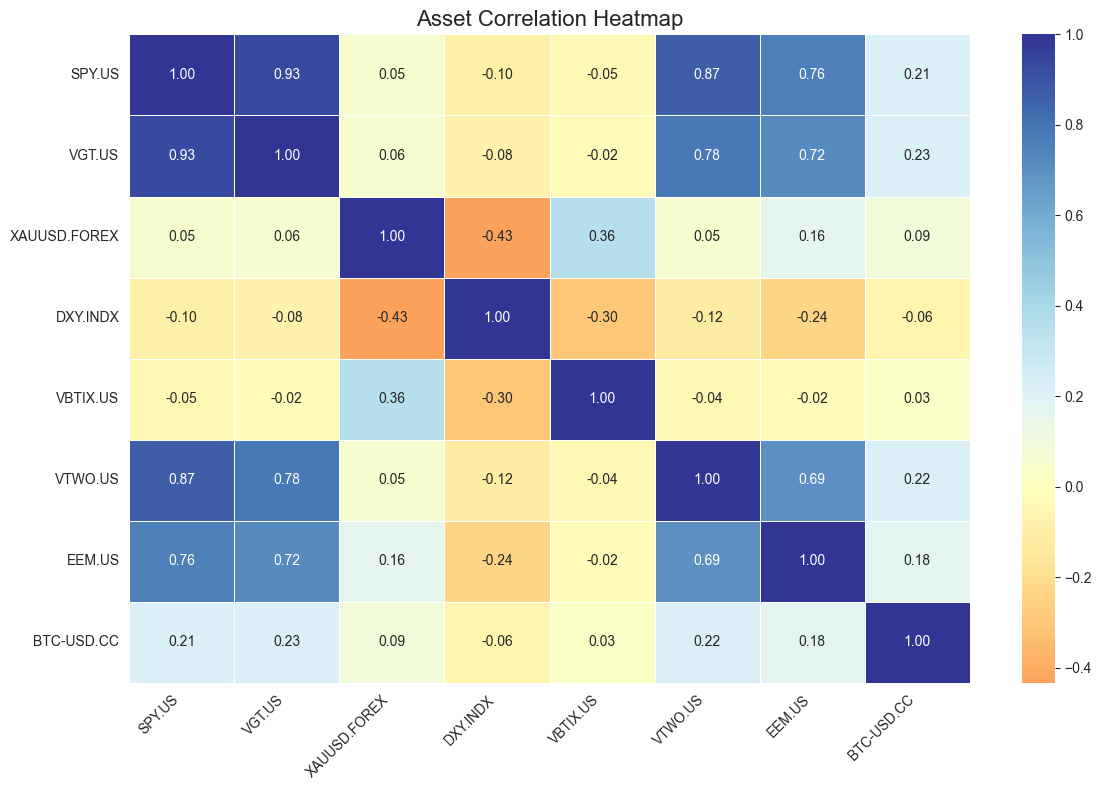

In [2]:
# create a dataframe with the daily changes of the prices
df_eod_prices_pct_changes = df_eod_prices.pct_change().dropna()

# Calculate correlations
correlation_matrix = df_eod_prices_pct_changes.corr()

# Create heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', center=0, cbar=True, linewidths=0.5, fmt=".2f")
plt.title("Asset Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

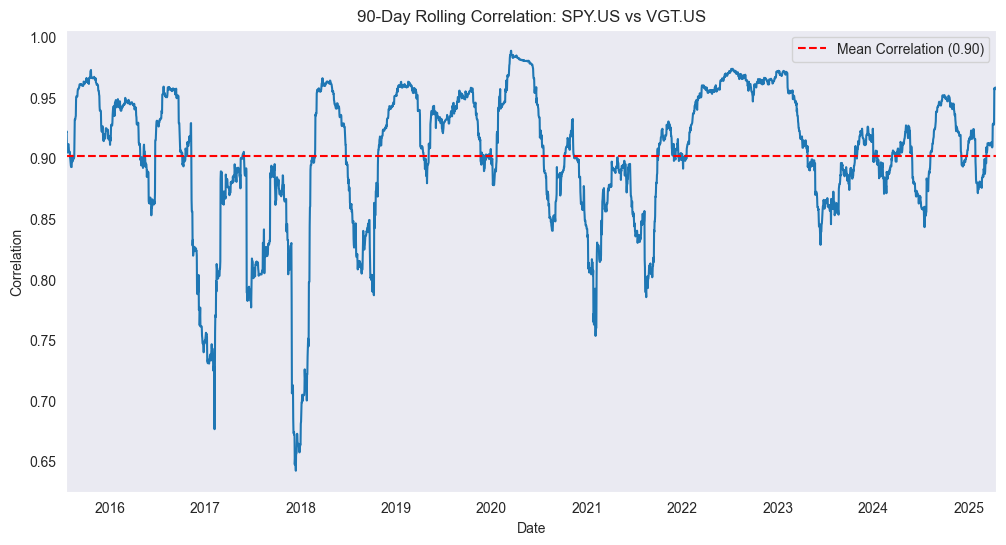

In [3]:
window_size = 90
asset1, asset2 = 'SPY.US', 'VGT.US'

# Calculate rolling correlation
rolling_corr = df_eod_prices_pct_changes[asset1].rolling(window=window_size).corr(df_eod_prices_pct_changes[asset2])
rolling_corr.dropna(inplace=True)

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr.plot(title=f"{window_size}-Day Rolling Correlation: {asset1} vs {asset2}")
plt.axhline(y=rolling_corr.mean(), color='r', linestyle='--', label=f"Mean Correlation ({rolling_corr.mean():.2f})")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

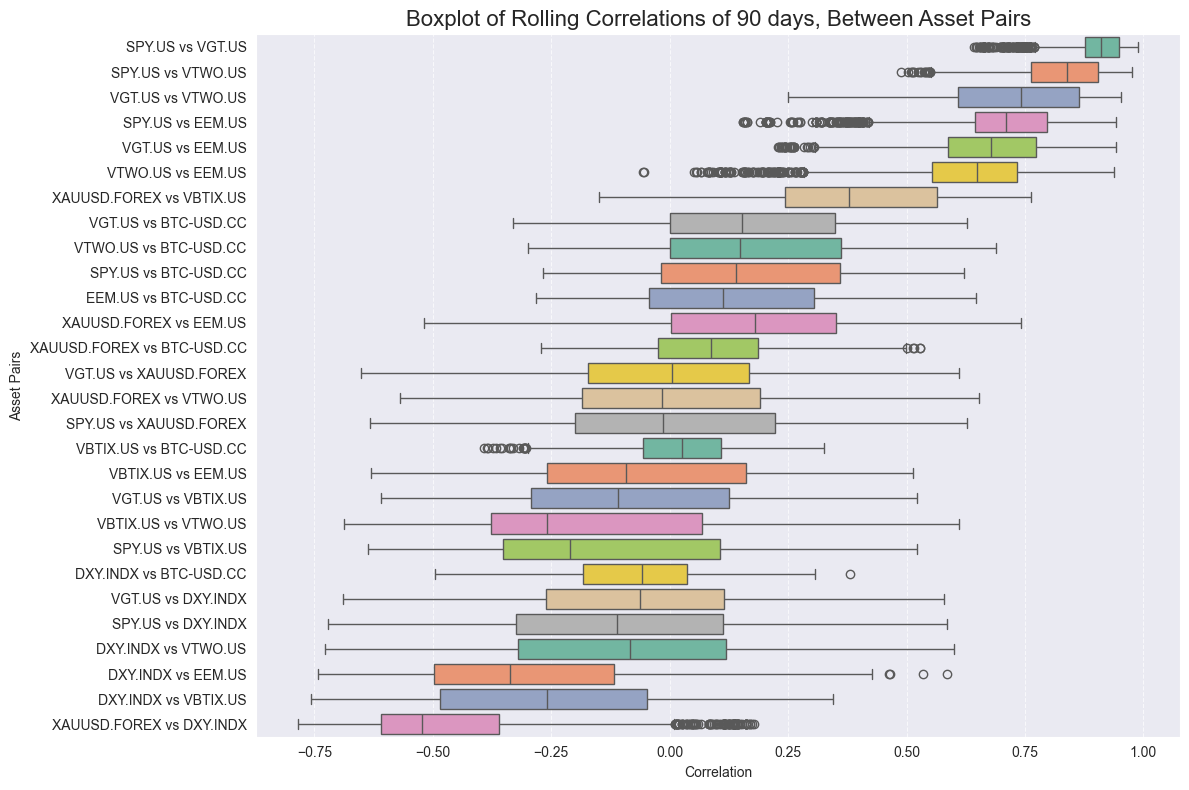

In [5]:
window_size = 90
rolling_corr_df = pd.DataFrame()

correlation_long = correlation_matrix.unstack().reset_index()
correlation_long.columns = ['Asset 1', 'Asset 2', 'Correlation']
correlation_long = correlation_long[correlation_long['Asset 1'] != correlation_long['Asset 2']]
correlation_long = correlation_long.drop_duplicates(subset=['Correlation']).sort_values(by='Correlation', ascending=False)

for _, row in correlation_long.iterrows():
    asset1, asset2 = row['Asset 1'], row['Asset 2']
    rolling_corr = df_eod_prices_pct_changes[asset1].rolling(window=window_size).corr(df_eod_prices_pct_changes[asset2])
    rolling_corr_df[f"{asset1} vs {asset2}"] = rolling_corr

rolling_corr_df.dropna(inplace=True)

plt.figure(figsize=(12, 8))
sns.boxplot(data=rolling_corr_df, orient='h', palette="Set2")
plt.title(f"Boxplot of Rolling Correlations of {window_size} days, Between Asset Pairs", fontsize=16)
plt.xlabel("Correlation")
plt.ylabel("Asset Pairs")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

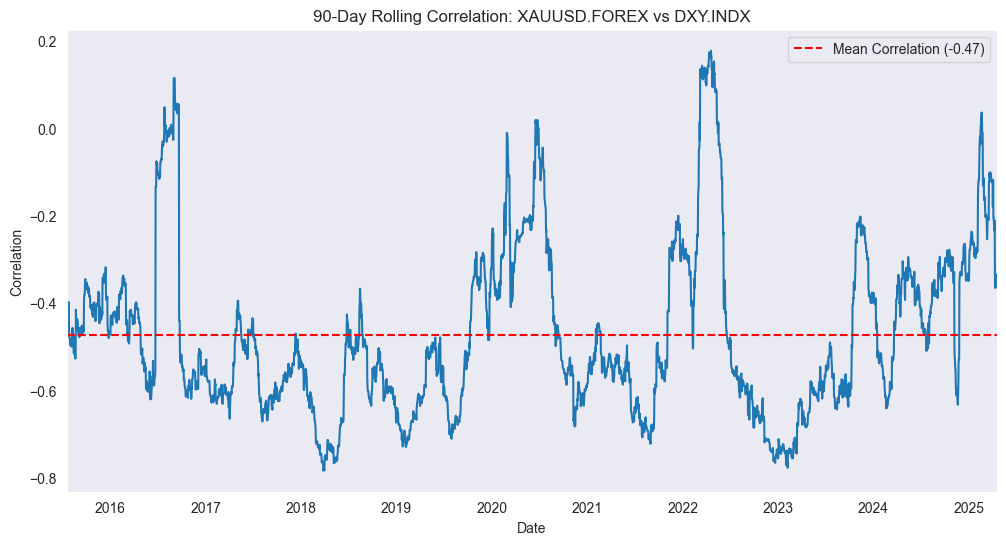

In [6]:
window_size = 90
asset1, asset2 = 'XAUUSD.FOREX', 'DXY.INDX'

# Calculate rolling correlation
rolling_corr = df_eod_prices_pct_changes[asset1].rolling(window=window_size).corr(df_eod_prices_pct_changes[asset2])
rolling_corr.dropna(inplace=True)

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr.plot(title=f"{window_size}-Day Rolling Correlation: {asset1} vs {asset2}")
plt.axhline(y=rolling_corr.mean(), color='r', linestyle='--', label=f"Mean Correlation ({rolling_corr.mean():.2f})")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='date'>

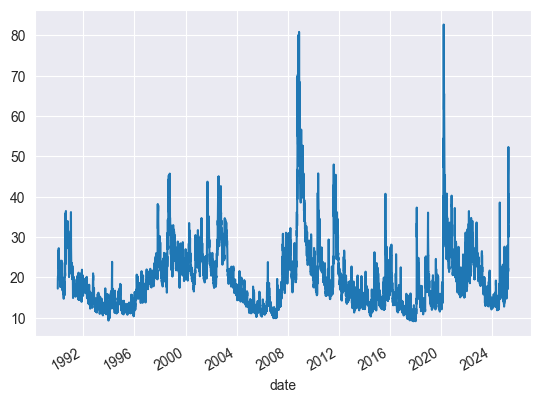

In [7]:
ticker = 'VIX.INDX'
url = f'https://eodhd.com/api/eod/{ticker}?api_token={api_token}&order=d&fmt=json'
data = requests.get(url)

if data.status_code != 200:
    print(f"Error: {data.status_code}")
    print(data.text)

data = data.json()
df_vix = pd.DataFrame(data)
df_vix = df_vix.set_index('date')
df_vix.rename(columns={'close': ticker}, inplace=True)
df_vix = df_vix[ticker]
df_vix.index = pd.to_datetime(df_vix.index)
df_vix.plot()

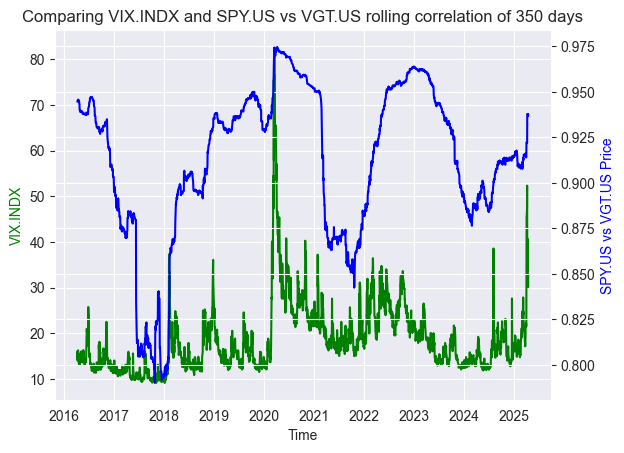

In [8]:
window_size = 350
asset1, asset2 = 'SPY.US', 'VGT.US'
pair_name = f'{asset1} vs {asset2}'
rolling_corr = df_eod_prices_pct_changes[asset1].rolling(window=window_size).corr(df_eod_prices_pct_changes[asset2])
rolling_corr.index = pd.to_datetime(rolling_corr.index)

# name the column
rolling_corr.name = pair_name
df_vix_with_rolling_corr = pd.concat([df_vix, rolling_corr], axis=1).dropna()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_vix_with_rolling_corr.index, df_vix_with_rolling_corr['VIX.INDX'], 'g-')
ax2.plot(df_vix_with_rolling_corr.index, df_vix_with_rolling_corr[pair_name], 'b-')

ax1.set_xlabel('Time')
ax1.set_ylabel('VIX.INDX', color='g')
ax2.set_ylabel(f'{pair_name} Price', color='b')

plt.title(f'Comparing VIX.INDX and {pair_name} rolling correlation of {window_size} days')
plt.show()